
Processando página 4
Para parar: feche o navegador
Erro durante a rolagem: Message: invalid session id: session deleted as the browser has closed the connection
from disconnected: not connected to DevTools
  (Session info: chrome=140.0.7339.128); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#invalidsessionidexception
Stacktrace:
	GetHandleVerifier [0x0x6cd2a3+66419]
	GetHandleVerifier [0x0x6cd2e4+66484]
	(No symbol) [0x0x4a4bd3]
	(No symbol) [0x0x494070]
	(No symbol) [0x0x4b277b]
	(No symbol) [0x0x517a45]
	(No symbol) [0x0x5321b9]
	(No symbol) [0x0x510e16]
	(No symbol) [0x0x4e25ce]
	(No symbol) [0x0x4e34a4]
	GetHandleVerifier [0x0x915ee3+2461619]
	GetHandleVerifier [0x0x910f66+2441270]
	GetHandleVerifier [0x0x6f6242+234258]
	GetHandleVerifier [0x0x6e6208+168664]
	GetHandleVerifier [0x0x6ed1ad+197245]
	GetHandleVerifier [0x0x6d55f8+100040]
	GetHandleVerifier [0x0x6d5792+100450]
	GetHandleVerifier [0x0x6bf74a+10266

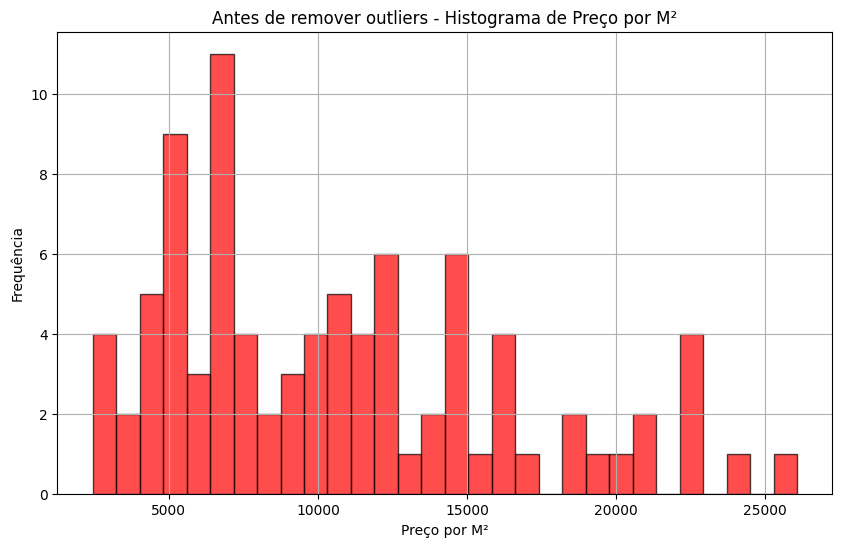

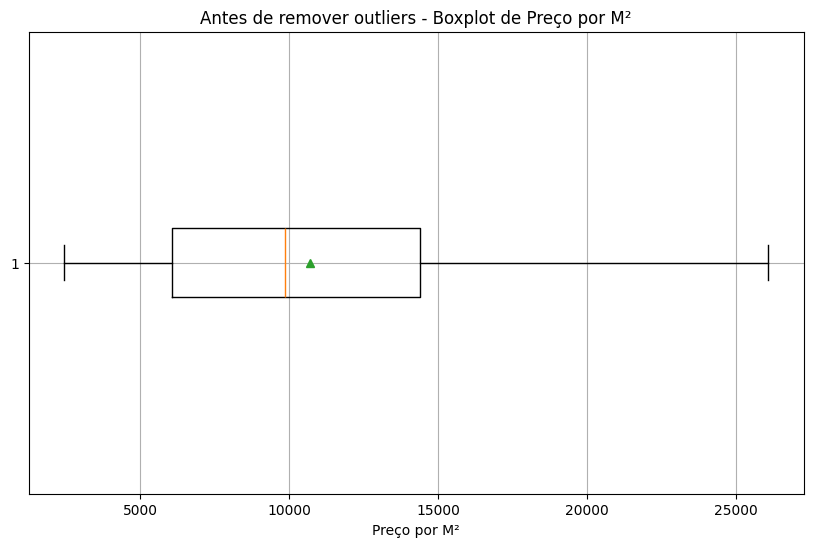


Estatísticas após a remoção de outliers:
Média Aritmética: 10701,70
Média Ponderada: 11542,12
Mediana: 9846,48
Moda: 6400,00
Coeficiente de Variação: 0,5371
Total de Linhas: 89


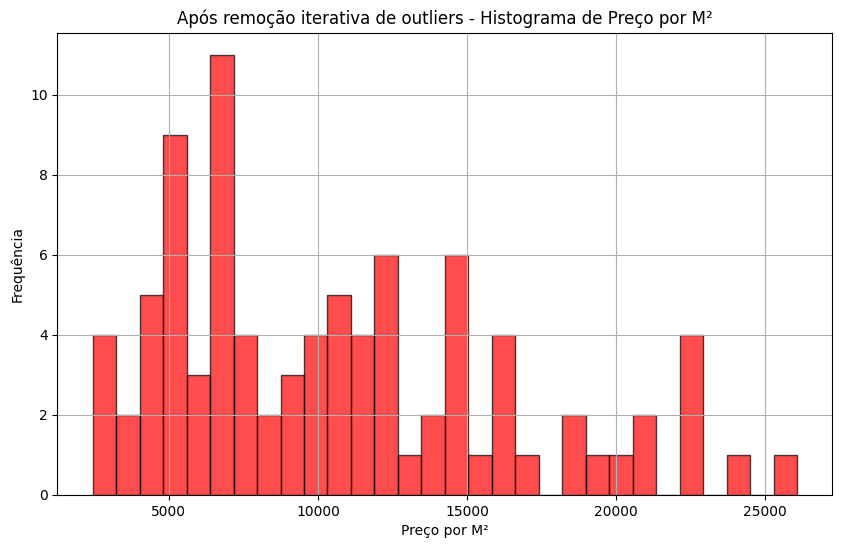

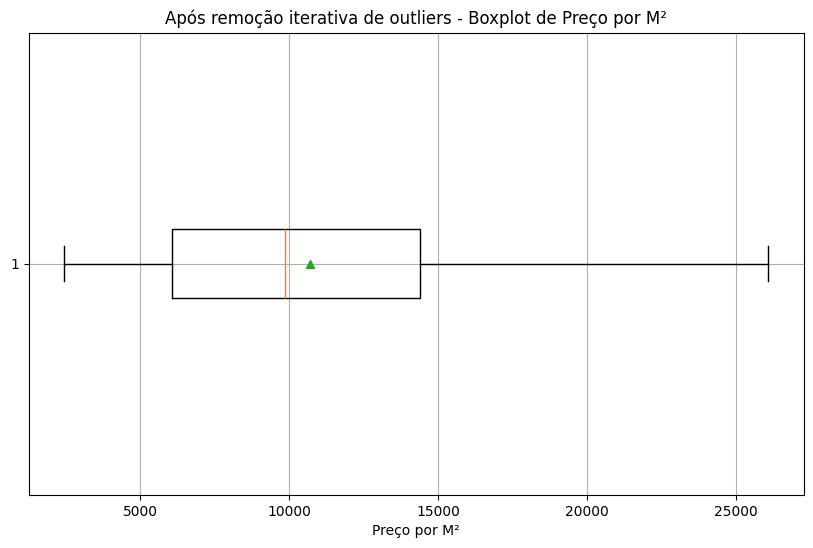


DataFrame após remoção iterativa de outliers:


,Localidade,Endereco,M2,Preco,R$/M2
0,"Sala/Conjunto para comprar com 64 m², 2 banhei...",Avenida Engenheiro Luiz Carlos Berrini,64.0,950000.0,14843.750000
1,"Apartamento para comprar com 115 m², 3 quartos...",Rua Bahia,115.0,2180000.0,18956.521739
2,"Apartamento para comprar com 78 m², 3 quartos,...",Rua Urussuí,78.0,960100.0,12308.974359
3,"Apartamento para comprar com 86 m², 2 quartos,...",Rua Pascal,86.0,850100.0,9884.883721
4,"Sobrado para comprar com 170 m², 3 quartos, 1 ...",Rua Cabaxi,170.0,530000.0,3117.647059
...,...,...,...,...,...
84,"Apartamento para comprar com 70 m², 2 quartos,...",Rua Nossa Senhora da Saúde,70.0,640100.0,9144.285714
85,"Apartamento para comprar com 88 m², 3 quartos,...",Avenida Joaquina Ramalho,88.0,790000.0,8977.272727
86,"Cobertura para comprar com 100 m², 2 quartos, ...",Rua Itajibá,100.0,1200100.0,12001.000000
87,"Casa de condomínio para comprar com 70 m², 3 q...",Rua São Serapião,70.0,424550.0,6065.000000



Dados finais salvos em: dados_final_20250915-190537.csv


In [1]:
import pandas as pd
import re
import numpy as np
import warnings
from scipy.stats import zscore
import time
import random
import undetected_chromedriver as uc
from fake_useragent import UserAgent
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os
from IPython.display import clear_output, display
from bs4 import BeautifulSoup

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    PLOTTING_AVAILABLE = True
except:
    print("Matplotlib não disponível. Os gráficos não serão gerados.")
    PLOTTING_AVAILABLE = False

warnings.filterwarnings("ignore")

def configure_driver():
    try:
        options = uc.ChromeOptions()
        ua = UserAgent()
        user_agent = ua.random
        options.add_argument(f'user-agent={user_agent}')
        options.add_argument('--disable-gpu')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument('--disable-notifications')
        options.add_argument('--disable-popup-blocking')
        options.add_argument('--disable-blink-features=AutomationControlled')
        
        driver = uc.Chrome(options=options)
        
        width = random.randint(1050, 1200)
        height = random.randint(800, 960)
        driver.set_window_size(width, height)
        
        return driver
    except Exception as e:
        print(f"Erro ao configurar o driver: {e}")
        return None

def add_random_actions(driver):
    try:
        driver.execute_script("""
            var event = new MouseEvent('mousemove', {
                'view': window,
                'bubbles': true,
                'cancelable': true,
                'clientX': arguments[0],
                'clientY': arguments[1]
            });
            document.dispatchEvent(event);
        """, random.randint(0, 800), random.randint(0, 600))
        time.sleep(random.uniform(0.5, 1.5))
    except Exception as e:
        print(f"Erro nas ações aleatórias: {e}")

def verificar_carregamento_completo(driver, timeout=15):
    print("\nVerificando carregamento completo...")
    last_count = 0
    stable_count = 0
    start_time = time.time()
    
    while time.time() - start_time < timeout:
        elementos = driver.find_elements(By.CLASS_NAME, "flex.flex-col.grow.min-w-0")
        current_count = len(elementos)
        print(f"\rElementos encontrados: {current_count}", end="")
        
        if current_count == last_count:
            stable_count += 1
            if stable_count >= 3:
                print(f"\nCarregamento estabilizou com {current_count} elementos")
                return current_count
        else:
            stable_count = 0
            last_count = current_count
            start_time = time.time()
        
        time.sleep(1)
    
    print(f"\nTimeout atingido. Último número de elementos: {last_count}")
    return last_count

def scroll_page(driver):
    try:
        last_height = driver.execute_script("return document.body.scrollHeight")
        current_position = 0
        scroll_step = 300
        
        while current_position < last_height:
            current_position = min(current_position + scroll_step, last_height)
            driver.execute_script(f"window.scrollTo(0, {current_position});")
            time.sleep(random.uniform(0.2, 0.35))
            
            if random.random() < 0.2:
                add_random_actions(driver)
            
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height > last_height:
                last_height = new_height
            
            if current_position >= last_height:
                print("\nFim da página atingido. Aguardando carregamento final...")
                time.sleep(2)
                return verificar_carregamento_completo(driver)
        
        return verificar_carregamento_completo(driver)
        
    except Exception as e:
        print(f"Erro durante a rolagem: {e}")
        return 0

def extrair_dados_anuncio(anuncio_soup):
    dados = {}
    
    try:
        # Extrai localização
        localizacao_element = anuncio_soup.find("h2", {"data-cy": "rp-cardProperty-location-txt"})
        if localizacao_element:
            dados['Localidade'] = localizacao_element.text.strip().replace("Apartamento para comprar em", "").strip()
            
        # Extrai endereço
        endereco_element = anuncio_soup.find("p", {"data-cy": "rp-cardProperty-street-txt"})
        if endereco_element:
            dados['Endereco'] = endereco_element.text.strip()
            
        # Extrai área (m²)
        area_element = anuncio_soup.find("li", attrs={"data-cy": "rp-cardProperty-propertyArea-txt"})
        if area_element:
            area_text = area_element.text.strip()
            match = re.search(r'(\d+(?:\.|,)?\d*)\s*m²', area_text)
            if match:
                area_str = match.group(1).replace('.', '').replace(',', '.')
                dados['M2'] = float(area_str)
        
        # Método alternativo para encontrar área
        if 'M2' not in dados:
            for elemento in anuncio_soup.find_all(['li', 'span', 'h3']):
                if elemento.text and 'm²' in elemento.text:
                    match = re.search(r'(\d+(?:\.|,)?\d*)\s*m²', elemento.text)
                    if match:
                        area_str = match.group(1).replace('.', '').replace(',', '.')
                        dados['M2'] = float(area_str)
                        break

        # Extrai características (quartos, banheiros, vagas)
        caracteristicas = anuncio_soup.find_all("li", class_="flex row items-center gap-0-5")
        for item in caracteristicas:
            texto = item.text.strip()
            if item.get('data-cy') == 'rp-cardProperty-bedroomQuantity-txt':
                dados['Quartos'] = int(re.search(r'(\d+)', texto).group(1))
            elif item.get('data-cy') == 'rp-cardProperty-bathroomQuantity-txt':
                dados['Banheiros'] = int(re.search(r'(\d+)', texto).group(1))
            elif item.get('data-cy') == 'rp-cardProperty-parkingSpacesQuantity-txt':
                dados['Vagas'] = int(re.search(r'(\d+)', texto).group(1))
                
        # Extrai preço
        preco = None
        
        # Primeira tentativa: classe específica
        preco_element = anuncio_soup.find("p", class_="text-2-25 text-feedback-success-110 font-semibold")
        if not preco_element:
            preco_element = anuncio_soup.find("p", class_="text-2-25 text-neutral-120 font-semibold")
        
        if preco_element:
            preco_texto = preco_element.text.strip()
            preco_match = re.search(r'R\$\s*([\d.,]+)', preco_texto)
            if preco_match:
                preco = float(preco_match.group(1).replace('.', '').replace(',', '.'))
        
        # Segunda tentativa: procura por qualquer elemento com padrão de preço
        if not preco:
            for elemento in anuncio_soup.find_all(['p', 'span', 'div']):
                texto = elemento.text.strip()
                if 'R$' in texto and len(texto) < 50:
                    preco_match = re.search(r'R\$\s*([\d.,]+)', texto)
                    if preco_match:
                        preco = float(preco_match.group(1).replace('.', '').replace(',', '.'))
                        break
        
        if preco:
            dados['Preco'] = preco
        else:
            print("\nNão foi possível encontrar o preço do imóvel")
            return None
            
        # Extrai taxas (condomínio e IPTU)
        taxas_element = anuncio_soup.find("p", class_="text-1-75 text-neutral-110")
        if taxas_element:
            taxas_texto = taxas_element.text.strip()
            cond_match = re.search(r'Cond\.\s*R\$\s*([\d.,]+)', taxas_texto)
            iptu_match = re.search(r'IPTU\s*R\$\s*([\d.,]+)', taxas_texto)
            
            if cond_match:
                dados['Condominio'] = float(cond_match.group(1).replace('.', '').replace(',', '.'))
            if iptu_match:
                dados['IPTU'] = float(iptu_match.group(1).replace('.', '').replace(',', '.'))
        
        # Calcula preço por m²
        if 'Preco' in dados and 'M2' in dados and dados['M2'] > 0:
            dados['R$/M2'] = dados['Preco'] / dados['M2']
            
    except Exception as e:
        print(f"\nErro ao extrair dados do anúncio: {e}")
        return None
        
    return dados

def extrair_dados_pagina(url, max_paginas=10):
    driver = None
    data_list = []
    pagina_atual = 1
    
    try:
        driver = configure_driver()
        if not driver:
            return None
            
        driver.get(url)
        time.sleep(3)
        
        while pagina_atual <= max_paginas:
            try:
                driver.current_url
            except:
                print("\nNavegador foi fechado. Salvando dados...")
                return salvar_dados(data_list)
                
            clear_output(wait=True)
            print(f"\nProcessando página {pagina_atual}")
            print("Para parar: feche o navegador")
            
            try:
                WebDriverWait(driver, 15).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "flex.flex-col.grow.min-w-0"))
                )
                
                num_elementos = scroll_page(driver)
                if num_elementos == 0:
                    print("Nenhum elemento encontrado após scroll")
                    break
                    
                print(f"\nIniciando extração de {num_elementos} elementos...")
                
                elementos = driver.find_elements(By.CLASS_NAME, "flex.flex-col.grow.min-w-0")
                for idx, elemento in enumerate(elementos, 1):
                    try:
                        print(f"\rProcessando elemento {idx}/{num_elementos}", end="")
                        html_content = elemento.get_attribute('outerHTML')
                        soup = BeautifulSoup(html_content, 'html.parser')
                        dados = extrair_dados_anuncio(soup)
                        
                        if dados:
                            data_list.append(dados)
                    except Exception as e:
                        print(f"\nErro ao processar elemento {idx}: {e}")
                        continue
                
                print(f"\nTotal de dados coletados até agora: {len(data_list)}")
                
                try:
                    next_button = driver.find_element(By.CSS_SELECTOR, 'button[data-testid="next-page"]')
                    if not (next_button.is_enabled() and "disabled" not in next_button.get_attribute("class")):
                        print("\nNão há mais páginas para processar")
                        break
                        
                    driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", next_button)
                    time.sleep(random.uniform(1, 2))
                    next_button.click()
                    time.sleep(random.uniform(4, 6))
                    pagina_atual += 1
                    
                except Exception as e:
                    print(f"\nErro ao processar próxima página: {e}")
                    break
                
            except Exception as e:
                print(f"\nErro ao processar página: {e}")
                break
    
    except Exception as e:
        print(f"\nErro durante a extração: {e}")
    
    finally:
        try:
            if driver:
                driver.quit()
        except:
            pass
    
    return salvar_dados(data_list)

def salvar_dados(data_list):
    if data_list:
        df = pd.DataFrame(data_list)
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f'dados_parciais_{timestamp}.csv'
        df.to_csv(filename, index=False)
        print(f"\nDados salvos em: {filename}")
        return df
    return None

def calcular_estatisticas(df):
    if 'R$/M2' in df.columns:
        media_aritmetica = df['R$/M2'].mean()
        media_ponderada = np.average(df['R$/M2'], weights=df['M2'])
        mediana = df['R$/M2'].median()
        moda = df['R$/M2'].mode()[0] if not df['R$/M2'].mode().empty else np.nan
        coef_var = df['R$/M2'].std() / df['R$/M2'].mean()
        total_linhas = len(df)

        print(f"Média Aritmética: {media_aritmetica:.2f}".replace('.', ','))
        print(f"Média Ponderada: {media_ponderada:.2f}".replace('.', ','))
        print(f"Mediana: {mediana:.2f}".replace('.', ','))
        print(f"Moda: {moda:.2f}".replace('.', ','))
        print(f"Coeficiente de Variação: {coef_var:.4f}".replace('.', ','))
        print(f"Total de Linhas: {total_linhas}")

def graficos(df, title_prefix=""):
    if not PLOTTING_AVAILABLE:
        print("Matplotlib não está disponível. Pulando geração de gráficos.")
        return
        
    if 'R$/M2' in df.columns:
        try:
            plt.figure(figsize=(10, 6))
            plt.hist(df['R$/M2'], bins=30, color='red', edgecolor='black', alpha=0.7)
            plt.title(f'{title_prefix}Histograma de Preço por M²')
            plt.xlabel('Preço por M²')
            plt.ylabel('Frequência')
            plt.grid(True)
            plt.show()
            
            plt.figure(figsize=(10, 6))
            plt.boxplot(df['R$/M2'], vert=False, showmeans=True)
            plt.title(f'{title_prefix}Boxplot de Preço por M²')
            plt.xlabel('Preço por M²')
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Erro ao gerar gráficos: {e}")

def remover_outliers_iqr(df, fator=1.5):
    if 'R$/M2' in df.columns:
        Q1 = df['R$/M2'].quantile(0.25)
        Q3 = df['R$/M2'].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - fator * IQR
        limite_superior = Q3 + fator * IQR
        return df[(df['R$/M2'] >= limite_inferior) & (df['R$/M2'] <= limite_superior)]
    return df

def remover_outliers_zscore(df, threshold=3):
    if 'R$/M2' in df.columns:
        z_scores = np.abs(zscore(df['R$/M2']))
        return df[z_scores < threshold]
    return df

def remover_outliers_iterativo(df, threshold=3, fator=1.5, max_iter=10):
    for _ in range(max_iter):
        df_old = df.copy()
        df = remover_outliers_iqr(df, fator)
        df = remover_outliers_zscore(df, threshold)
        if len(df) == len(df_old):
            break
    return df

def analisar_site(url_inicial):
    try:
        print("Iniciando extração de dados...")
        print("Para parar a extração, feche o navegador")
        
        df = extrair_dados_pagina(url_inicial)
        if df is not None and not df.empty:
            print("\nEstatísticas antes da remoção de outliers:")
            calcular_estatisticas(df)
            graficos(df, title_prefix="Antes de remover outliers - ")
            
            df_cleaned = remover_outliers_iterativo(df)
            
            print("\nEstatísticas após a remoção de outliers:")
            calcular_estatisticas(df_cleaned)
            graficos(df_cleaned, title_prefix="Após remoção iterativa de outliers - ")
            
            print("\nDataFrame após remoção iterativa de outliers:")
            display(df_cleaned)
            
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            filename = f'dados_final_{timestamp}.csv'
            df_cleaned.to_csv(filename, index=False)
            print(f"\nDados finais salvos em: {filename}")
            
            return df_cleaned
    except Exception as e:
        print(f"Erro na análise: {e}")
    
    return None

if __name__ == "__main__":
    url_inicial = input("Digite a URL para análise: ")
    df_resultado = analisar_site(url_inicial)